***
# W5: Monet GAN
***

This project is a submission for [this Kaggle competition](https://www.kaggle.com/competitions/gan-getting-started/overview) that challenges us to model and train a Generative Adversarial Network to apply the style of Monet paintings onto real photographs.

Generative Adversarial Networks (GANs) are deep learning neural network models that use two types of models internally to produce original generated data. There is one NN that tries to generate the desired output, and another that tries to classify between real and generated outputs. These two models cyclically train eachother to improve classification and generative capabilites.

For this project, I will be using a CycleGAN to learn the style of Monet paintings and apply them onto real photos. The dataset for this competition includes 300 Monet paintings and ~7000 real photos. All images are 256x256px with 3 color channels. The images are given in both jpg and tfrec format.

#### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import shutil

***
# Exploratory Data Analysis
***

### Exploration

In [2]:
monet_path = 'data/monet_jpg/'
photo_path = 'data/photo_jpg/'
monet_files = [f for f in os.listdir(monet_path) if f.endswith('.jpg')]
photo_files = [f for f in os.listdir(photo_path) if f.endswith('.jpg')]

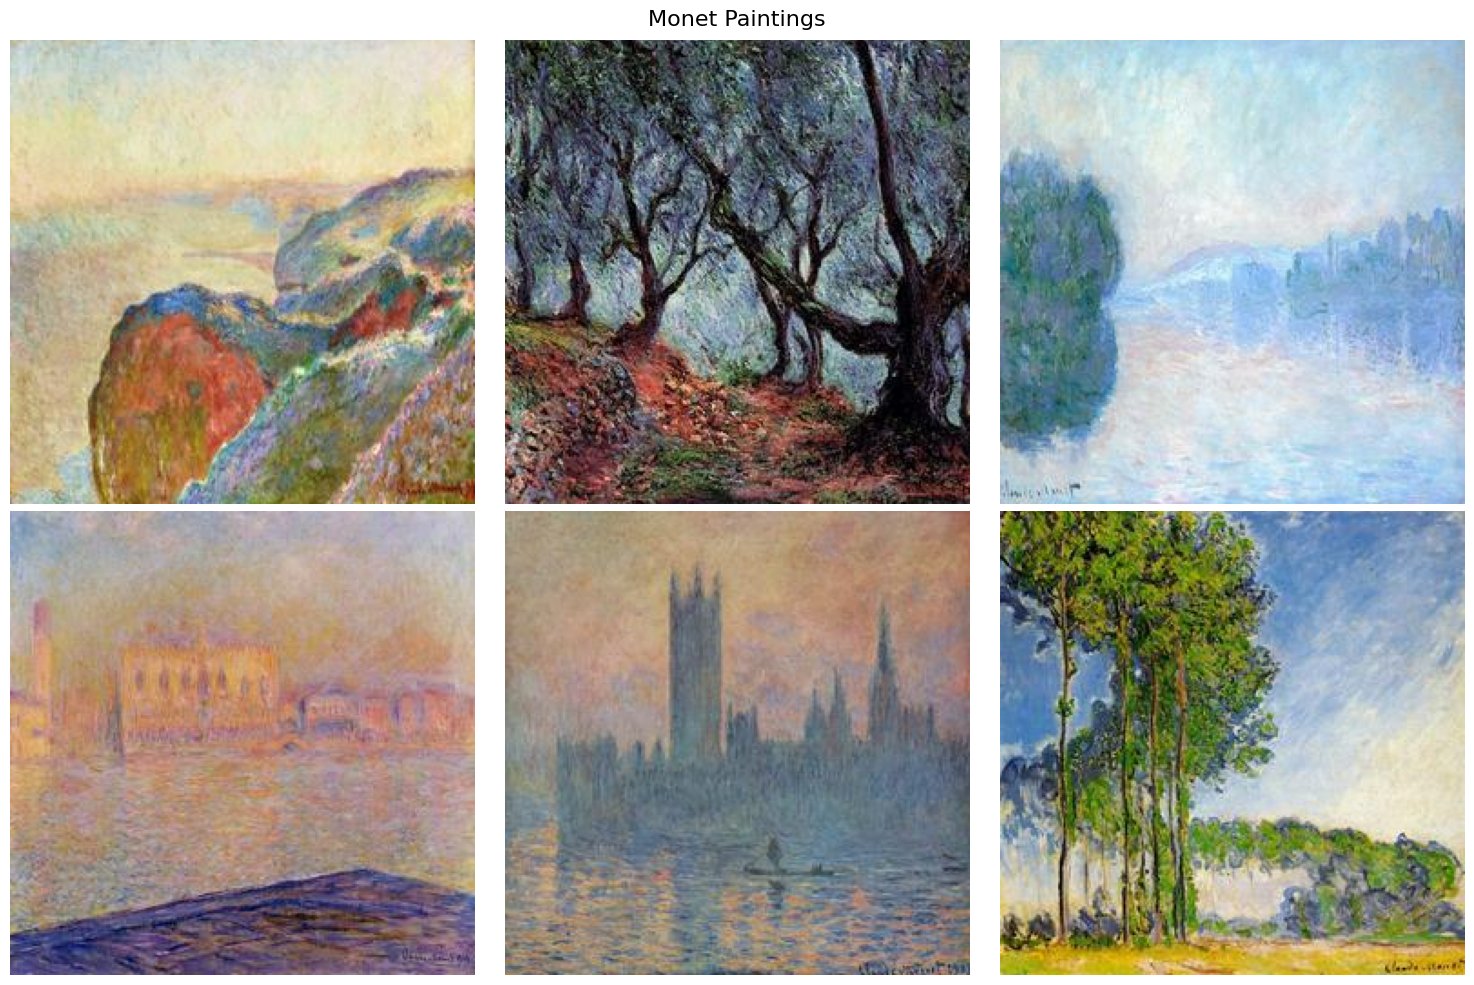

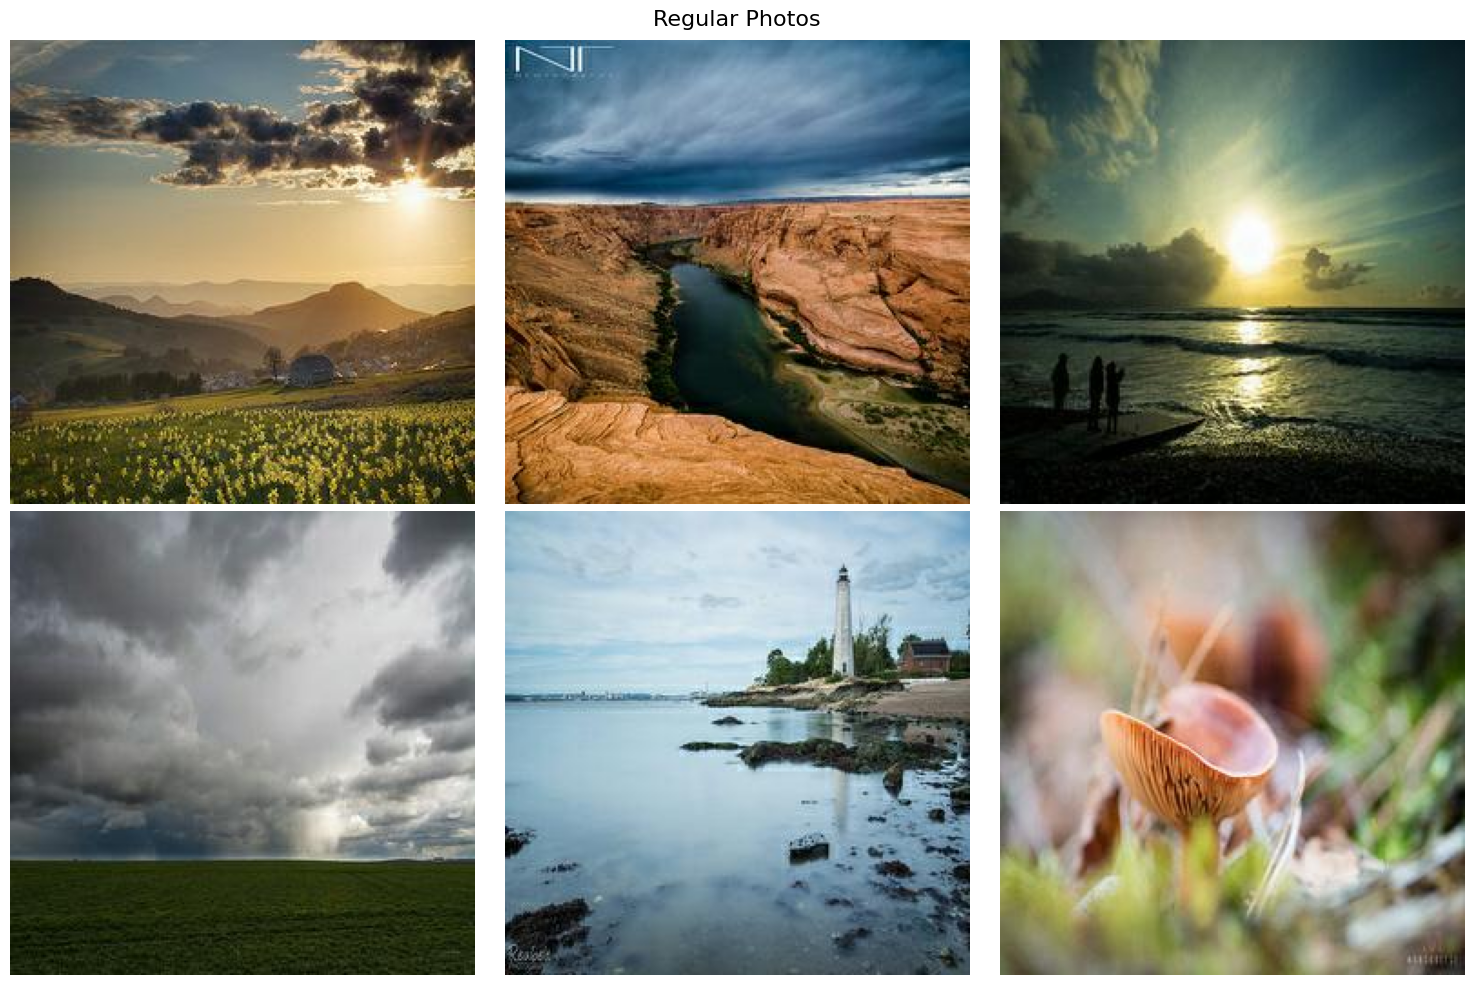

In [3]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Monet Paintings', fontsize=16)

for idx in range(6):
    row = idx // 3
    col = idx % 3
    
    img_path = os.path.join(monet_path, monet_files[idx])
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Regular Photos', fontsize=16)

for idx in range(6):
    row = idx // 3
    col = idx % 3
    
    img_path = os.path.join(photo_path, photo_files[idx])
    img = Image.open(img_path)
    axes[row, col].imshow(img)
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

The Monet paintings have a very distinct style. Objects and colors have softer boundaries, often blurring into eachother. The range of colors seems to be lower as well, and they are generally less bright/intense.

In [4]:
def analyze_color_statistics(file_list, folder_path, sample_size=300):
    color_stats = {'mean_rgb': [], 'std_rgb': [], 'brightness': [], 'contrast': []}
    
    sample_files = np.random.choice(file_list, min(sample_size, len(file_list)), replace=False)
    
    for filename in sample_files:
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path)
        
        img_array = np.array(img)
        color_stats['mean_rgb'].append(np.mean(img_array, axis=(0, 1)))
        color_stats['std_rgb'].append(np.std(img_array, axis=(0, 1)))
        color_stats['brightness'].append(np.mean(img_array))
        color_stats['contrast'].append(np.std(img_array))
    
    return color_stats

monet_colors = analyze_color_statistics(monet_files, monet_path)
photo_colors = analyze_color_statistics(photo_files, photo_path)

monet_mean_rgb = np.array(monet_colors['mean_rgb'])
photo_mean_rgb = np.array(photo_colors['mean_rgb'])

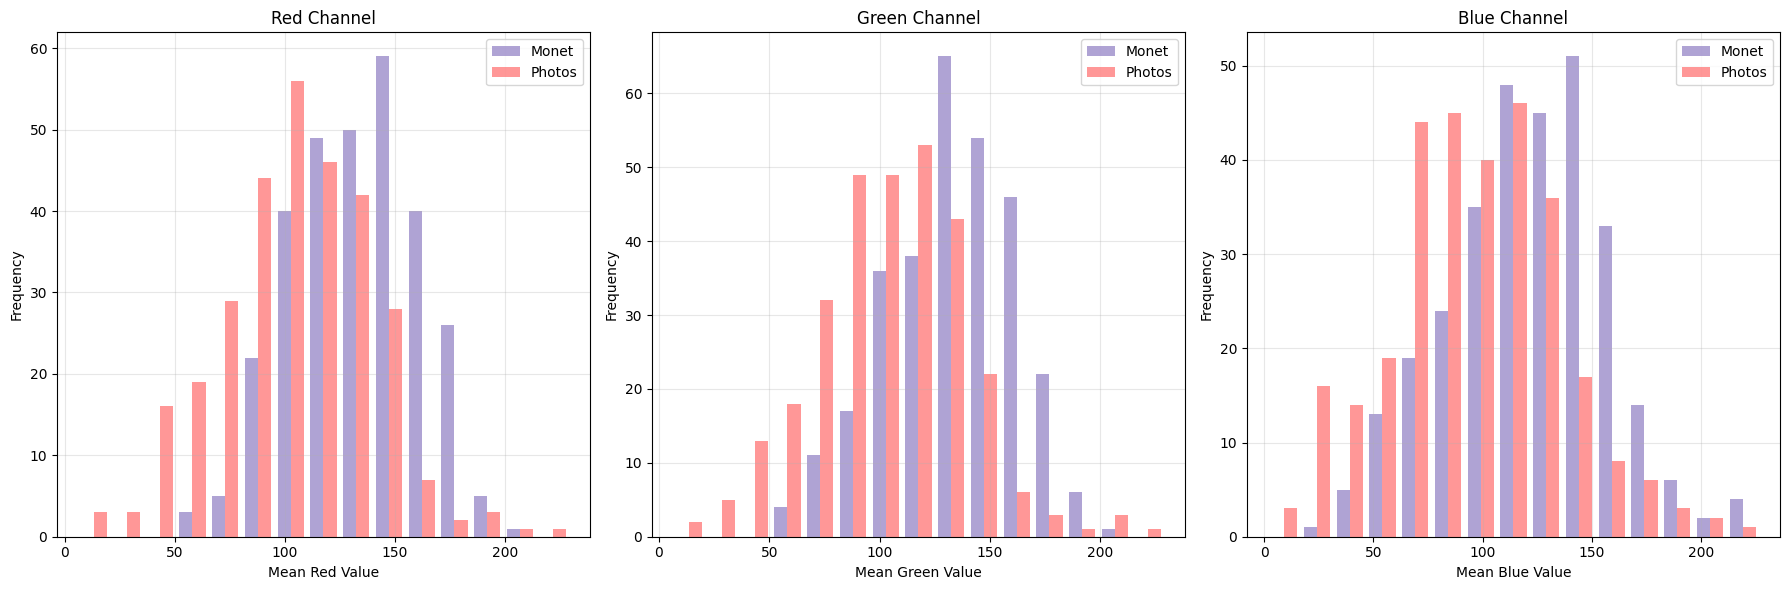

Monet Avg RGB: R=133.0, G=133.7, B=121.6
Photo Avg RGB: R=104.6, G=103.9, B=95.3



In [5]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6))

channels = ['Red', 'Green', 'Blue']
colors_rgb = ['red', 'green', 'blue']

for i, (channel, color) in enumerate(zip(channels, colors_rgb)):
    axes[i].hist([monet_mean_rgb[:, i], photo_mean_rgb[:, i]], 
                    bins=15, alpha=0.7, label=['Monet', 'Photos'], 
                    color=['#8E7CC3', '#FF6B6B'])
    axes[i].set_title(f'{channel} Channel')
    axes[i].set_xlabel(f'Mean {channel} Value')
    axes[i].set_ylabel('Frequency')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Monet Avg RGB: R={np.mean(monet_mean_rgb[:, 0]):.1f}, G={np.mean(monet_mean_rgb[:, 1]):.1f}, B={np.mean(monet_mean_rgb[:, 2]):.1f}")
print(f"Photo Avg RGB: R={np.mean(photo_mean_rgb[:, 0]):.1f}, G={np.mean(photo_mean_rgb[:, 1]):.1f}, B={np.mean(photo_mean_rgb[:, 2]):.1f}")
print()

The data seems to be against that initial observation. The average RGB values are slightly higher in intensity than the photos.

Monet Paintings:
Avg brightness: 129.4
Avg contrast: 50.6
Photos:
Avg brightness: 101.2
Avg contrast: 58.2


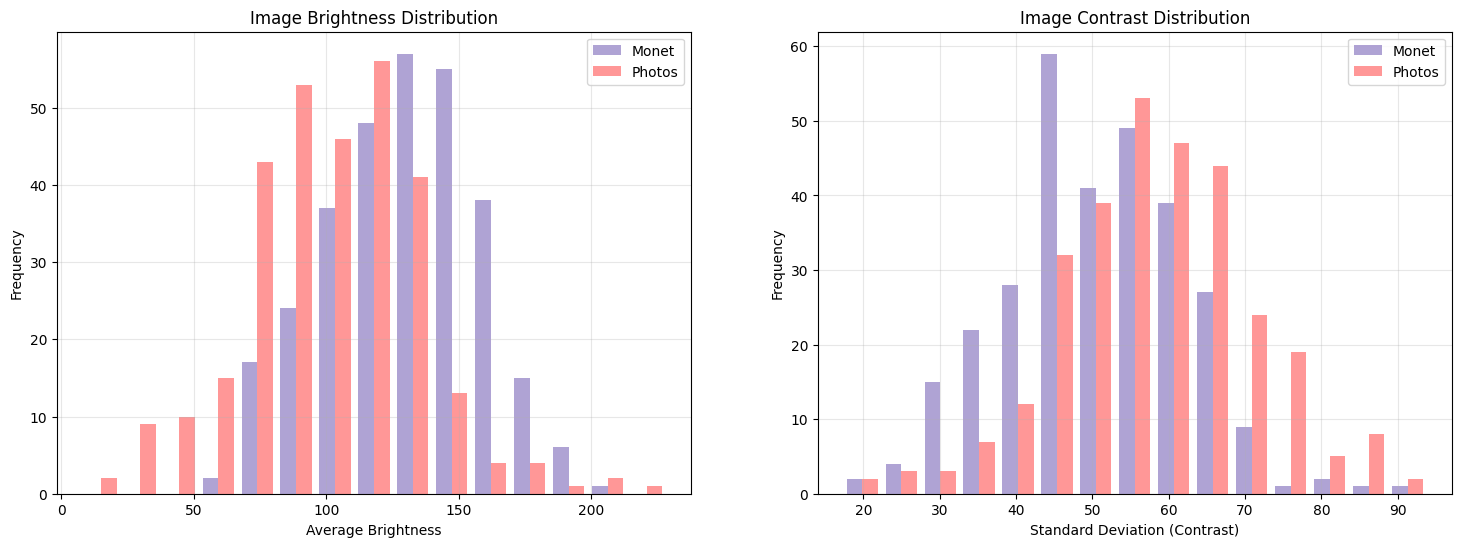

In [6]:
fig, axes = plt.subplots(ncols=2, figsize=(18, 6))

axes[0].hist([monet_colors['brightness'], photo_colors['brightness']], 
                bins=15, alpha=0.7, label=['Monet', 'Photos'], 
                color=['#8E7CC3', '#FF6B6B'])
axes[0].set_title('Image Brightness Distribution')
axes[0].set_xlabel('Average Brightness')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist([monet_colors['contrast'], photo_colors['contrast']], 
                bins=15, alpha=0.7, label=['Monet', 'Photos'], 
                color=['#8E7CC3', '#FF6B6B'])
axes[1].set_title('Image Contrast Distribution')
axes[1].set_xlabel('Standard Deviation (Contrast)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

print(f"Monet Paintings:")
print(f"Avg brightness: {np.mean(monet_colors['brightness']):.1f}")
print(f"Avg contrast: {np.mean(monet_colors['contrast']):.1f}")
print(f"Photos:")
print(f"Avg brightness: {np.mean(photo_colors['brightness']):.1f}")
print(f"Avg contrast: {np.mean(photo_colors['contrast']):.1f}")

The brightness of the Monet paintings is higher on average, but the variance in colors/contrast is higher in photos. This supports my initial observation that the photos have a wider range of colors.

### Preprocessing

To prepare the images for use in the GAN, I needed to load them efficiently. The batch size also affected how the GAN would be trained, with lower batch sizes creating more steps per epoch, and vice versa.

I also normalized the images to a range of [-1, 1] in order to improve the training process. When using values with high ranges, certain images could potentially dominate the gradient calculations, causing vanishing or exploding gradients. This also helps the model be more general, especially if incorporating images of different file formats.

In [7]:
monet_files = tf.data.Dataset.list_files(monet_path + '*.jpg')
photo_files = tf.data.Dataset.list_files(photo_path + '*.jpg')

def load_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    return (tf.cast(img, tf.float32)) / 127.5 - 1.0

In [8]:
BUFFER_SIZE = 1000
BATCH_SIZE = 32

monet = (monet_files
         .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
         .cache()
         .shuffle(BUFFER_SIZE)
         .repeat()
         .batch(BATCH_SIZE)
         .prefetch(tf.data.AUTOTUNE))

photos = (photo_files
          .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
          .cache()
          .shuffle(BUFFER_SIZE)
          .batch(BATCH_SIZE)
          .prefetch(tf.data.AUTOTUNE))

### Plan of Analysis

My plan was to develop the initial version of the model and do some visual testing/tuning. By that I mean I would check the results of the training at every epoch to see if the model is developing properly and that the outputs are good. 

After some tuning, I would run the notebook on Kaggle and make a submission to get a score on their MiFID score. 

MiFID (Memorization-informed Fréchet Inception Distance) is a modified FID score that uses a NN to measure Fréchet distance between real and generated images, as well as memorization distance. Memorization distance is another type of distance between real and generated images that takes into account all training samples at once.

I will do some more tuning as appropriate after getting official scores.

***
# Modelling
***

The CycleGAN architecture has 4 parts:
- monet_gen: generates Monet-style paintings from photos
- photo_gen: generates photos from Monet-style paintings
- monet_disc: discriminator that classifies real and fake Monet paintings
- photo_disc: discriminator that classifies real and fake photos

The **generators** take in an input of size 256x256x3 and use multiple convolution layers to downsample the image to a representative size, then upsamples with transpose convolution layers back to the original dimensions. This architecture allows the generator to condense the smaller and larger patterns of the images, then expand upon them with the desired style.

The **discriminators** similarly downsample the image multiple times to a much smaller size, then makes predictions on each cell of whether it is real or generated. This convolution structure also allows it to learn large and small patterns in the images, and then make predictions on sections of the image, rather than the image as a whole. This gives the generator more information to work with when training.

In [9]:
img_size = (256, 256, 3)
gamma_init = keras.initializers.RandomNormal(0.0, 0.02)
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy) # performance boost

In [10]:
def downsample(filters, kernel_size, use_normalization=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    ds = keras.Sequential()
    ds.add(layers.Conv2D(filters, kernel_size, strides=2, padding='same', 
                         kernel_initializer=initializer, use_bias=False))
    if use_normalization:
        ds.add(keras.layers.GroupNormalization(groups=1, 
                                               gamma_initializer=gamma_init))
    ds.add(layers.LeakyReLU())
    
    return ds

In [11]:
def upsample(filters, kernel_size):
    initializer = tf.random_normal_initializer(0.0, 0.02)
    us = keras.Sequential()
    us.add(layers.Conv2DTranspose(filters, kernel_size, strides=2, padding='same',
                                  kernel_initializer=initializer, use_bias=False))
    us.add(keras.layers.GroupNormalization(groups=1, 
                                           gamma_initializer=gamma_init))
    us.add(layers.ReLU())
    
    return us

## Generator

I chose 4 downsampling layers (with one intermedite layer) and 4 upsampling layers for my model. This was so that the image can be boiled down to important features, but not too much to the point where too much information is lost.

More downsampling layers would potentially learn the patterns of the data better, but may end up overfitting. This would work better for larger image sizes. Too little downsampling images would not be able to learn the features of the images enough, and ultimately make a worse conversion of styles.

There are also skip connections between the downsampling and upsampling layers. This is called a U-Net architecture, and it connects down and upsampling layers of corresponding size. This allows the generator to remember information about more fine details of the image as it is upsampling. Having no skip connections would potentially distort the images excessively, since too much information would be lost during the downsampling process.

When tuning the hyperparameters and structure of the CycleGAN, I ended up making two version of the generator, a regular and a light generator. The light generator uses less down/upsampling layers in order to speed up training time and potentially fit the data better by being simpler.

In [12]:
def Generator():
    init = tf.random_normal_initializer(0.0, 0.02)
    inputs = layers.Input(shape=img_size)
    x = inputs                                   # 256x256x3
    
    # downsampling
    x = downsample(64, 4)(x)                     # 128x128x64
    skip1 = x
    x = downsample(128, 4)(x)                    # 64x64x128  
    skip2 = x
    x = downsample(256, 4)(x)                    # 32x32x256
    skip3 = x
    x = downsample(512, 4)(x)                    # 16x16x512
    skip4 = x
    
    x = downsample(512, 4)(x)                    # 8x8x512
    
    # upsampling with skip connections
    x = upsample(512, 4)(x)                      # 16x16x512
    x = layers.Concatenate()([x, skip4])        # 16x16x1024
    
    x = upsample(256, 4)(x)                      # 32x32x256  
    x = layers.Concatenate()([x, skip3])        # 32x32x512
    
    x = upsample(128, 4)(x)                      # 64x64x128
    x = layers.Concatenate()([x, skip2])        # 64x64x256
    
    x = upsample(64, 4)(x)                       # 128x128x64
    x = layers.Concatenate()([x, skip1])        # 128x128x67
    
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', 
                                     activation='tanh',
                                     kernel_initializer=init)(x)  # 256x256x3
    
    return keras.Model(inputs, x, name='Generator')

In [13]:
def LightGenerator():
    """Lighter generator for faster training"""
    init = tf.random_normal_initializer(0.0, 0.02)
    inputs = layers.Input(shape=img_size)
    x = inputs                                   # 128x128x3
    
    # Fewer downsampling layers for lighter model
    x = downsample(64, 4)(x)                     # 64x64x64
    skip1 = x
    x = downsample(128, 4)(x)                    # 32x32x128  
    skip2 = x
    x = downsample(256, 4)(x)                    # 16x16x256
    skip3 = x
    
    x = downsample(256, 4)(x)                    # 8x8x256
    
    # Upsampling with skip connections
    x = upsample(256, 4)(x)                      # 16x16x256
    x = layers.Concatenate()([x, skip3])        # 16x16x512
    
    x = upsample(128, 4)(x)                      # 32x32x128
    x = layers.Concatenate()([x, skip2])        # 32x32x256
    
    x = upsample(64, 4)(x)                       # 64x64x64
    x = layers.Concatenate()([x, skip1])        # 64x64x128
    
    x = layers.Conv2DTranspose(3, 4, strides=2, padding='same', 
                                     activation='tanh',
                                     kernel_initializer=init)(x)  # 128x128x3
    
    return keras.Model(inputs, x, name='LightGenerator')

## Discriminator

The discriminator downsamples the image multiple times to detect the small and large patterns in the image, and then classifies each part of the image as real or fake.

In [14]:
def Discriminator():
    init = tf.random_normal_initializer(0.0, 0.02)
    inputs = layers.Input(shape=img_size, name='discriminator_input')
    x = inputs
    
    x = downsample(64, 4, use_normalization=False)(x)      # 128x128x64
    x = downsample(128, 4)(x)                              # 64x64x128
    x = downsample(256, 4)(x)                              # 32x32x256
    x = downsample(512, 4)(x)                              # 16x16x512
    
    x = layers.Conv2D(1, 4, strides=1, padding='same', 
                      kernel_initializer=init)(x)           # 16x16x1
    
    return keras.Model(inputs, x, name='Discriminator')

## CycleGAN

In [15]:
monet_gen = LightGenerator()
monet_disc = Discriminator()
photo_gen = LightGenerator()
photo_disc = Discriminator()

In [ ]:
ex_img = next(iter(photos.take(1)))
ex1 = monet_gen(ex_img)

plt.subplot(1, 2, 1)
plt.imshow((ex_img[0] + 1) / 2)
plt.title('Input Photo')

plt.subplot(1, 2, 2)
plt.imshow((ex1[0] + 1) / 2)
plt.title('Generated Monet Image')

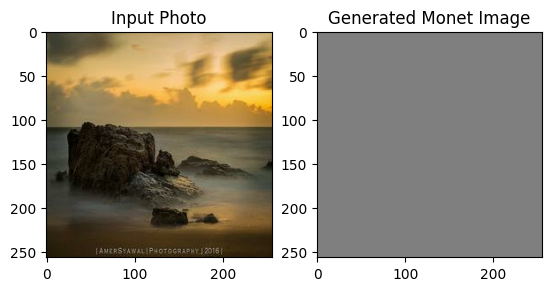

The untrained generator initially makes a blank image, since it doesn't know anything yet.

In [21]:
class CycleGAN(keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc,
                 lambda_cycle=10.0, lambda_identity=0.5):
        super(CycleGAN, self).__init__()
        self.m_gen = monet_gen  # Photo to Monet
        self.p_gen = photo_gen  # Monet to Photo
        self.p_disc = photo_disc  # Discriminator for Photos
        self.m_disc = monet_disc  # Discriminator for Monet paintings
        self.lambda_cycle = lambda_cycle
        self.lambda_identity = lambda_identity

    def compile(self, m_gen_optimizer, p_gen_optimizer,
                p_disc_optimizer, m_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn=keras.losses.MeanAbsoluteError(), 
                identity_loss_fn=keras.losses.MeanAbsoluteError()):
        super(CycleGAN, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            fake_monet = self.m_gen(real_photo, training=True) # photo to monet
            fake_photo = self.p_gen(real_monet, training=True) # monet to photo

            disc_real_monet = self.m_disc(real_monet, training=True) # is real monet
            disc_fake_monet = self.m_disc(fake_monet, training=True) # is fake monet

            disc_real_photo = self.p_disc(real_photo, training=True) # is real photo
            disc_fake_photo = self.p_disc(fake_photo, training=True) # is fake photo

            # generator adversarial losses
            m_gen_loss = self.gen_loss_fn(disc_fake_monet)
            p_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # cycle consistency losses
            reconstructed_photo = self.p_gen(fake_monet, training=True)
            reconstructed_monet = self.m_gen(fake_photo, training=True)
            cycle_loss_photo = self.cycle_loss_fn(real_photo, reconstructed_photo, 
                                                  self.lambda_cycle)
            cycle_loss_monet = self.cycle_loss_fn(real_monet, reconstructed_monet, 
                                                  self.lambda_cycle)
            total_cycle_loss = cycle_loss_photo + cycle_loss_monet

            # identity losses
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)
            identity_loss_monet = self.identity_loss_fn(real_monet, same_monet, 
                                                        self.lambda_identity * 
                                                        self.lambda_cycle)
            identity_loss_photo = self.identity_loss_fn(real_photo, same_photo,
                                                        self.lambda_identity * 
                                                        self.lambda_cycle)

            # total generator losses
            total_m_gen_loss = (m_gen_loss + 
                                self.lambda_cycle * total_cycle_loss + 
                                self.lambda_identity * identity_loss_monet)
            total_p_gen_loss = (p_gen_loss + 
                                self.lambda_cycle * total_cycle_loss + 
                                self.lambda_identity * identity_loss_photo)
            
            # discriminator losses
            m_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            p_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # calculate the gradients for generators and discriminators
        m_gen_gradients = tape.gradient(total_m_gen_loss,
                                        self.m_gen.trainable_variables)
        p_gen_gradients = tape.gradient(total_p_gen_loss,
                                        self.p_gen.trainable_variables)
        
        m_disc_gradients = tape.gradient(m_disc_loss,
                                         self.m_disc.trainable_variables)
        p_disc_gradients = tape.gradient(p_disc_loss,
                                         self.p_disc.trainable_variables)
        
        # apply the gradients to the optimizers
        self.m_gen_optimizer.apply_gradients(zip(m_gen_gradients, 
                                        self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(p_gen_gradients, 
                                        self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(m_disc_gradients,
                                        self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(p_disc_gradients,
                                        self.p_disc.trainable_variables))
        
        return {"m_gen_loss": total_m_gen_loss,
                "p_gen_loss": total_p_gen_loss,
                "m_disc_loss": m_disc_loss,
                "p_disc_loss": p_disc_loss}

In [18]:
def disc_loss(real, fake):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    fake_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(fake), fake)
    return (real_loss + fake_loss) * 0.5

def gen_loss(fake):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(fake), fake)

def cycle_loss(real, reconstructed, lmbda):
    # both tensors need same dtype for mixed precision compatibility
    real = tf.cast(real, tf.float32)
    reconstructed = tf.cast(reconstructed, tf.float32)
    return tf.reduce_mean(tf.abs(real - reconstructed)) * lmbda

def identity_loss(real, same, lmbda):
    real = tf.cast(real, tf.float32)
    same = tf.cast(same, tf.float32)
    return tf.reduce_mean(tf.abs(real - same)) * lmbda * 0.5

The training steps of the CycleGAN involve calculating several types of loss. It generates and discriminates both types of images, and then needs to assign losses to both discriminators and generators in order to calculate their gradients.

I used binary crossentropy for the discriminator loss, as the discriminator needed to make a strict classification of what parts of the image seemed real or fake. The generator also uses binary crossentropy by comparing its generated image to a perfect scored representation (image of all 1's).

The CycleGAN also uses other kinds of loss, such as cycle loss and identity loss within its calculations. These are used to find the loss associated with images that are converted both ways (Monet -> photo -> back to Monet), and for identifying images that are generated into the same style (Monet -> Monet again).

The types of loss functions I chose include binary crossentropy and mean absolute error, which are basic standard for CycleGANs Other more complex losses such as perceptual loss may be suited for more complex CycleGANs, that also use multiple types of loss calculations.

## Training

This callback will display generated images at every epoch.

In [22]:
class CycleGANMonitor(keras.callbacks.Callback):
    def __init__(self, num_imgs=3):
        self.num_imgs = num_imgs

    def on_epoch_end(self, epoch, logs=None):
        fig, axes = plt.subplots(2, self.num_imgs, figsize=(15, 10))
        imgs = photos.take(self.num_imgs)
        for i, img in enumerate(imgs):
            img = next(iter(photos.take(1)))
            generated = self.model.m_gen(img, training=False)[0].numpy()
            generated = (generated * 127.5 + 127.5).astype(np.uint8)
            img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

            axes[0, i].imshow(img)
            axes[0, i].set_title('Input Photo')
            axes[0, i].axis('off')

            axes[1, i].imshow(generated)
            axes[1, i].set_title('Generated Monet')
            axes[1, i].axis('off')

        plt.suptitle(f'Epoch {epoch + 1}', fontsize=16)
        plt.show()

In [23]:
gan = CycleGAN(monet_gen, photo_gen, monet_disc, photo_disc)
gan.compile(
    m_gen_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_gen_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    m_disc_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_disc_optimizer=keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=gen_loss,
    disc_loss_fn=disc_loss,
    cycle_loss_fn=cycle_loss,
    identity_loss_fn=identity_loss,
)
display_callback = CycleGANMonitor(num_imgs=3)

In [ ]:
gan.fit(tf.data.Dataset.zip((monet, photos)), epochs=15, callbacks=[display_callback])

This is the final state of the CycleGAN (with more epochs). The full version was run in a Kaggle notebook in order to train faster and make the official submission.

***
# Results and Conclusions
***

My first model was making very blurry and colorless photos when generating, with generator losses in the 80s and 90s. I eventually figured out I was loading the data wrong, by not shuffling and not using the repeat() function. This mean that the training was only using a small amount of images per epoch (300) since that was the total amount of monet images.

I also was not using skip connections at the time, which was a huge problem.

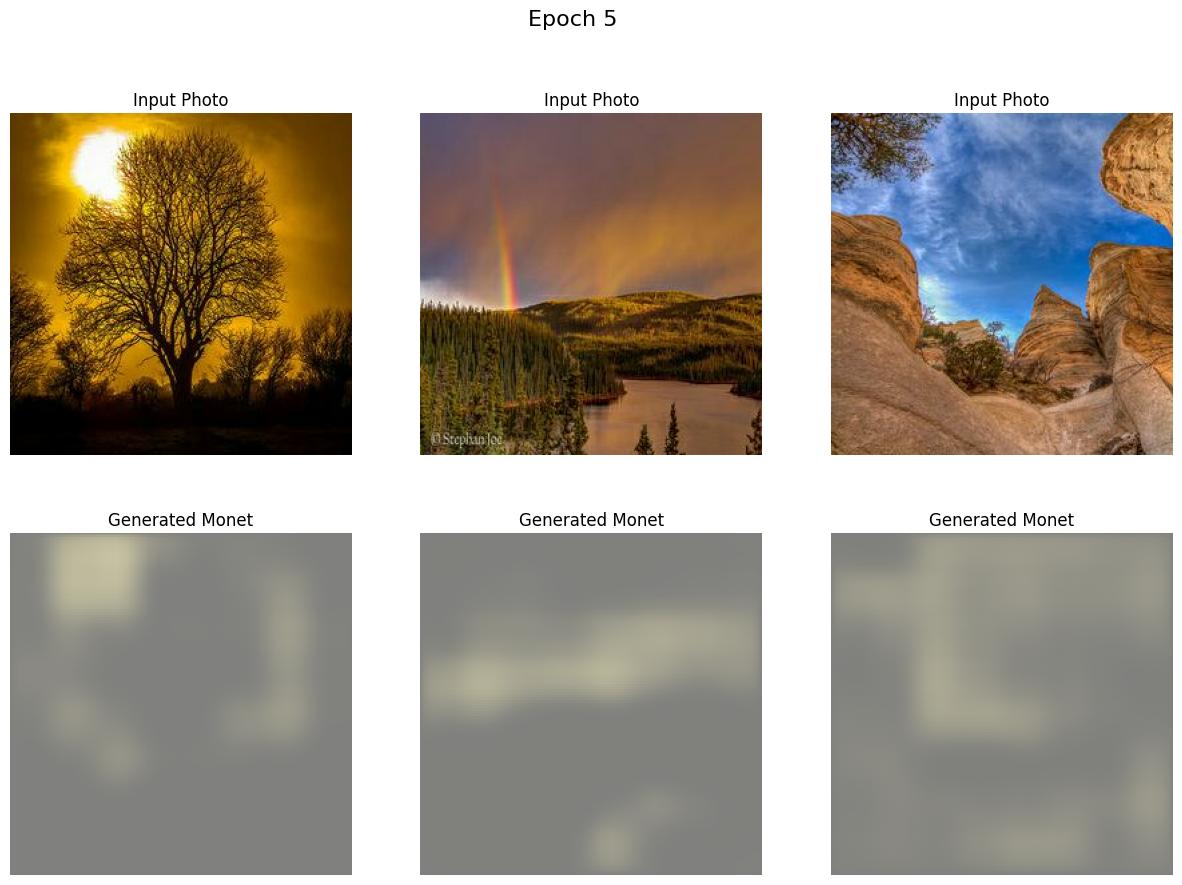

The training time was also taking very long. I experimented with the batch sizes, but there were memory issues when raising it past 32, so I stuck with that value.

My next version used the improved data processing, batch size, and complex architecture with skip connections and yielded significantly better results, with generator losses ranging from the 50s to the 20s by the end of it. The final score was a 63.

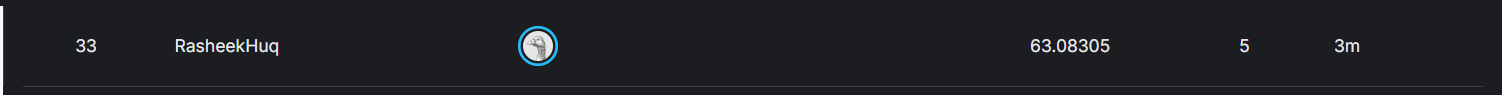

Sample generated images:

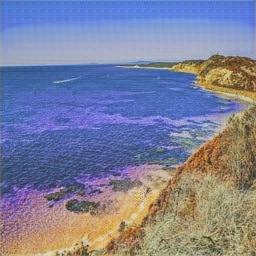

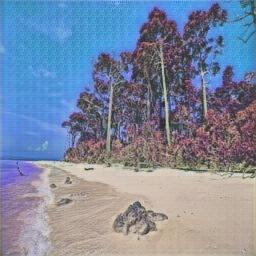

The results show a decent attempt at applying the Monet style onto photos, but is ultimately not super close when looking at it visually. It still looks like a real photo that has been transformed, although the colors are definitely moved towards the Monet style.

I also tried a simpler model with less down/upsampling layers in the generator, and got a worse MiFID score, but visually the images are very comparable. The training time was also much faster.

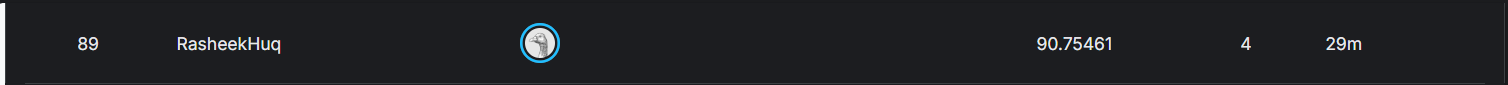

Sample generated images:

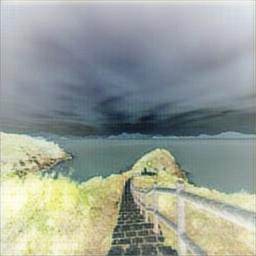

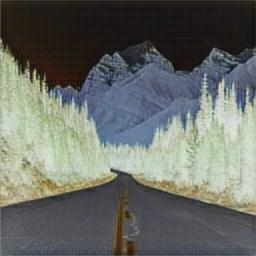

### Hyperparameter Tuning Summary

After making the initial model, I first needed to change the data preprocessing step by tuning the batch sizes and how the images were being loaded. This greatly increased performance, by giving the model more training information per epoch.

I then added skip connections into the generator, which was an even bigger help. These skip connections helped the generator preserve finer details in the later steps of the generation, making the image closer to the original while still applying the new style.

Afterwards, I tried using a simpler architecture to help speed up training time while preserving performance.

### Final Result

In [ ]:
SUBMIT = True

if SUBMIT:
    #! mkdir ../images
    photos_for_submission = (photo_files
                           .map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
                           .batch(1)
                           .prefetch(tf.data.AUTOTUNE))
    
    i = 1
    for img in photos_for_submission:
        prediction = monet_gen(img, training=False)[0].numpy()
        prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
        im = Image.fromarray(prediction)
        im.save("../images/" + str(i) + ".jpg")
        i += 1
        if i % 1000 == 0:
            print(f"Processed {i-1} images...")
    
    print(f"Total images generated: {i-1}")
    shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

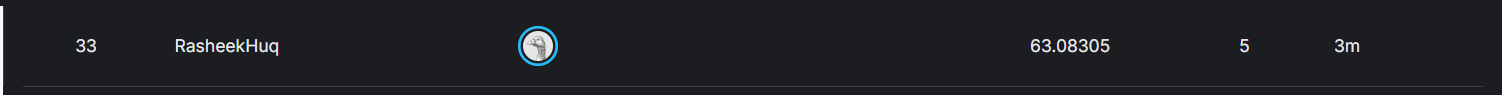

My final model got a MiFID score of 63.

## Conclusions

Ultimately, my model got a good MiFID score of 63, placing at rank 33. The initial models performed very poorly, but my adjustments helped a lot.

Initially, my data loading process and architecture were not doing well. This was because, as mentioned before, the loading process used a much smaller amount of images in the same order every epoch, making the training less exhaustive and diverse. My architecture was also somewhat mismatched in terms of layer counts.

Adding skip connections greatly increased performance by helping preserve context between down and upsampling layers.

During this project, I learned about the architecture of a CycleGAN in much more detail. I also learned about the importance of data preprocessing and loading procedures, and how much that would affect the training process.

If I had more time, I would try more variations of the generator and discriminator architectures, such as a ResNet instead of U-Net. I would also use more epochs for the training process to further refine the model.

### References

> 1. “I’m Something of a Painter Myself.” Kaggle, www.kaggle.com/competitions/gan-getting-started/overview. Accessed 2 Dec. 2025. 

> 2. Jang, Amy. “Monet Cyclegan Tutorial.” Kaggle, Kaggle, 29 Aug. 2020, www.kaggle.com/code/amyjang/monet-cyclegan-tutorial. 

> 3. A_K_Nain. “Keras Documentation: Cyclegan.” Keras, keras.io/examples/generative/cyclegan/. Accessed 2 Dec. 2025. 

*AI Use/Citation:*

Github Copilot (Claude) was used during the development of this project. It's use was limited to:
- syntax correction/improvement
- code suggestions for small operations
- improving formatting of code
- nicely formatting print statements and statistics
- suggesting certain functions for plots I was trying to make
- making plots look and scale better

All ideas for every step of the project came from me.